In [10]:
# use dream_proj conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
loader = read_data.DatasetLoader("mSalt")
across_species, treated_mice = loader.load_dataset()
across_species.log_scale_expr()
treated_mice.log_scale_expr()

max_lifespan = pd.read_csv('/cellar/users/zkoch/dream/utilities/animal_lifespans.csv', sep=',')

Loading dataset: mSalt


In [36]:
# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-1])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

# Compare DREAM expression across species

In [18]:
across_species.get_dream_gene_expression(
    #row_limiting_query="dna_repair_genes == 1"
    )
# take mean across numeric columns
across_species.dream_expression['mean_dream_reg_expr'] = across_species.dream_expression[across_species.dream_regulated_genes_w_expression].mean(axis=1)
across_species.dream_expression['median_dream_reg_expr'] = across_species.dream_expression[across_species.dream_regulated_genes_w_expression].median(axis=1)
# get species and tissue
across_species.dream_expression['species'] = across_species.dream_expression['sample_title'].apply(lambda x: x.split(", ")[1])
across_species.dream_expression['tissue'] = across_species.dream_expression['sample_title'].apply(lambda x: x.split(", ")[0])
# get max lifespan
across_species.dream_expression['max_lifespan'] = across_species.dream_expression['species'].map(max_lifespan.set_index('species')['max_lifespan'])
across_species.dream_expression['log_max_lifespan'] = np.log(across_species.dream_expression['max_lifespan'])


Converted DREAM genes to mouse genes
Found 269 DREAM genes with expression


In [22]:
# select the kidney samples that are Control or KU0063794
mice_to_add = treated_mice.dream_expression.query("tissue == 'kidney' and treatment in ['Control', 'KU0063794']").copy(deep = True)
mice_to_add['max_lifespan'] = mice_to_add['treatment'].map({'Control': 1000/365.25, 'KU0063794': 1150/365.25})
mice_to_add['log_max_lifespan']  = np.log(mice_to_add['max_lifespan'])
mice_to_add['tissue'] = 'Kidney'
# if KU0063794 add to species
mice_to_add['species'] = mice_to_add['treatment'].map({'Control': 'C57BL/6', 'KU0063794': 'C57BL/6 + KU0063794'})
# add to across_species
across_species.dream_expression = pd.concat([across_species.dream_expression, mice_to_add], axis=0)

In [19]:
# for the value of tissue that are Cerebellum replace with Brain
across_species.dream_expression['tissue'] = across_species.dream_expression['tissue'].replace('Cerebellum', 'Brain')

In [31]:
# capitalize first letter of each species valuye
across_species.dream_expression['species'] = across_species.dream_expression['species'].apply(lambda x: x[0].upper() + x[1:])

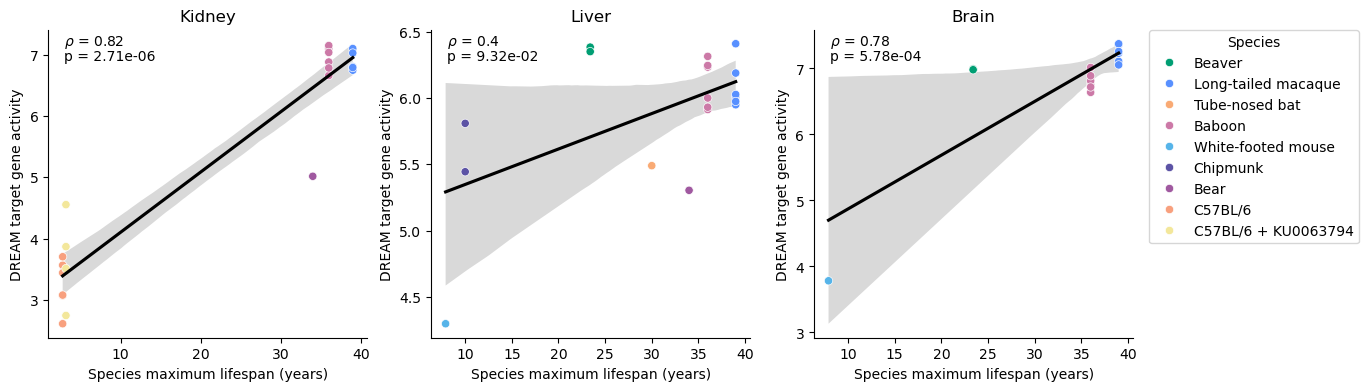

In [37]:
# plot the regression lines
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=False, sharey=False)
axes = axes.flatten()
species = across_species.dream_expression['species'].unique().tolist()
# for each tissue plot the regression line and scatter plot a subplot
for i, tissue in enumerate(['Kidney', 'Liver', 'Brain']):
    if tissue == 'Cerebellum':
        continue
    ax = axes[i]
    # get the data for the tissue
    tissue_data = across_species.dream_expression[across_species.dream_expression['tissue'] == tissue]
    # plot the regression line
    sns.regplot(x='max_lifespan', y='mean_dream_reg_expr', data=tissue_data, ax=ax, scatter=False, color = 'black', truncate=True)
    # plot the scatter plot
    sns.scatterplot(x='max_lifespan', y='mean_dream_reg_expr',hue = 'species', data=tissue_data, ax=ax, palette=my_categorical_palette, hue_order=species)
    # set x axis to log scale
    # unless it is the second plot 
    if i != 2:
        # remove the legend
        ax.get_legend().remove()
    # if it second plot add the legend off the plot to the right
    else:
        # with label Species
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Species')
    # set the title
    ax.set_title(tissue)
    # set the x label
    ax.set_xlabel('Species maximum lifespan (years)')
    # set the y label
    ax.set_ylabel('DREAM target gene activity')
    # add the spearman correlction as text to the plot (using $rho$)
    spearmanm, pval = spearmanr(tissue_data['max_lifespan'], tissue_data['mean_dream_reg_expr'])
    ax.text(0.05, 0.95, r'$\rho$ = ' + str(round(spearmanm, 2)), transform=ax.transAxes)
    # and add the pvalue below as text in scientific notation
    ax.text(0.05, 0.9, 'p = ' + str('{:.2e}'.format(pval)), transform=ax.transAxes)
sns.despine()

/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


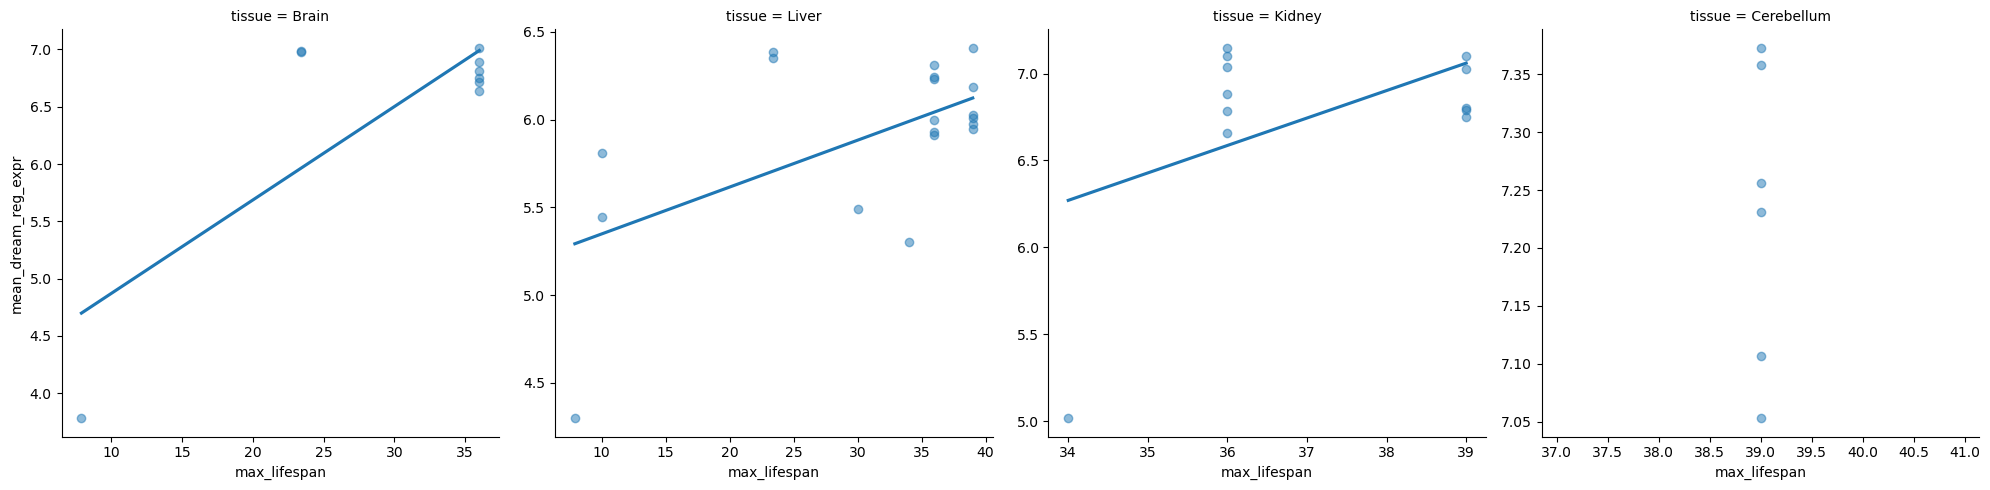

In [122]:
# no confidence intervals
sns.lmplot(col='tissue', y='mean_dream_reg_expr', x='max_lifespan', data=across_species.dream_expression, fit_reg=True, ci=None, sharex=False, sharey=False, scatter_kws={'alpha':0.5})

# Compare DREAM expression across treated mice

In [17]:
# get the expression of DREAM DNA repair genes in treated mice
treated_mice.get_dream_gene_expression(
    #row_limiting_query="dna_repair_genes == 1"
    )
treated_mice.dream_expression['mean_dream_reg_expr'] = treated_mice.dream_expression[treated_mice.dream_regulated_genes_w_expression].mean(axis=1)
treated_mice.dream_expression['treatment'] = treated_mice.dream_expression['sample_name'].str.split('_').str[0]
treated_mice.dream_expression['tissue'] = treated_mice.dream_expression['sample_name'].str.split('_').str[1]

Converted DREAM genes to mouse genes
Found 294 DREAM genes with expression


<Axes: xlabel='tissue', ylabel='mean_dream_reg_expr'>

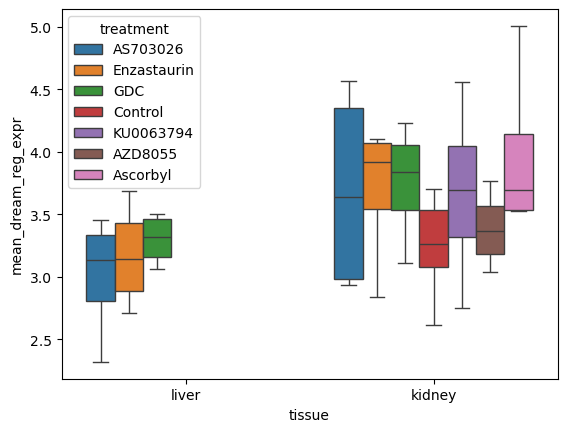

In [129]:
sns.boxplot(data = treated_mice.dream_expression,
            x = 'tissue', hue = 'treatment', 
            y = 'mean_dream_reg_expr', showfliers = False
            )